In [4]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
import torch
import torch.nn as nn
from helper_functions_preprocessing import PreProcessor

##Pytorch Stuff:
import torch.nn.functional as F

# Sklearn Stuff
import sklearn

# Plot stuff:
import seaborn as sns
import matplotlib.pyplot as plt

## Bayesian Optimization
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

import itertools


# DEL Mini-Challenge 1
Es sollen Immobillienobjekte klassifiziert werden. Von der FHNW haben wir einen Datensatz erhalten (Siehe beiliegendes EDA-Notebook), in denen wir vorraussagen sollen, um was für ein Wohnobjekt es sich handelt; Ist es ein Zimmer? Wohnung? Haus? Diese Challenge hatten wir gelöst, aber ohne Deep Learning. 
## Einführung
### Lösung der Mini-Challenge 1 für DEL
Wir benutzen ein Neutal-Network. Zur Erstellung wir das Deep-Learning Framework Pytorch benutzt.
### Ground Truth
Als Ground Truth bentzen wir das Modell, welches wir in der Challenge Immobillienrehcner benutzt haben. Mit diesem haben wir die Macro-F1 Score maximiert, da wir sowohl die Precision, als auch den Recall hoch haben möchten. Ebenfalls haben wir die "Macro" F1 Score optimiert, da wir eine starke Class-Imbalance haben.
### Grobübersicht Inhalt Datensatz
Es gab keine klare Beschreibung, wie gewisse Features (z.B. densities oder gde) zustande gekommen sind. Gde bezieht sich aber auf Gemeinden, in denen das Wohnobjekt liegt. Densities S bis L steht einfach für die Inensitäts des z.B. Waldes. Ist ein grosser Wald, welcher sehr dicht ist? -> ForestDensityL ist hoch. Dies wurde aber nicht zu 100% vom Challengeherausgeber bestätigt.


## Erstellung Modell Ground Truth

In [5]:
#read in data
csv_data = pd.read_csv('immo_dev_data.csv')
csv_data.head()

,Id,AreaLiving,AreaProperty,BuiltYear,FloorNumber,ForestDensityL,ForestDensityM,ForestDensityS,GroupNameDe,HouseObject,...,gde_private_apartments,gde_social_help_quota,gde_tax,gde_workers_sector1,gde_workers_sector2,gde_workers_sector3,gde_workers_total,location_has_street,location_is_complete,PurchasePrice
0,7135329,140.0,501.0,2016,NaN,0.418964,0.555985,0.730714,Haus,True,...,1358.0,3.660512,8.73,17.0,162.0,358.0,537.0,0,0,745000.0
1,7170979,143.0,277.0,2004,NaN,0.033259,0.074061,0.076468,Haus,True,...,3476.0,3.634717,6.13,0.0,2250.0,2787.0,5041.0,1,1,780000.0
2,7172246,160.0,712.0,1945,NaN,0.000000,0.000000,0.000000,Haus,True,...,2806.0,2.512344,9.79,167.0,1694.0,1138.0,2999.0,0,0,570000.0
3,7172252,351.0,496.0,2016,NaN,0.037575,0.000000,0.000000,Haus,True,...,131.0,1.734104,9.15,12.0,10.0,17.0,39.0,0,0,920000.0
4,7172733,400.0,1800.0,1975,NaN,0.095162,0.097193,0.153314,Haus,True,...,1181.0,1.056052,2.97,0.0,27.0,701.0,732.0,0,0,3950000.0


In [6]:
csv_data.columns

Index(['Id', 'AreaLiving', 'AreaProperty', 'BuiltYear', 'FloorNumber',
       'ForestDensityL', 'ForestDensityM', 'ForestDensityS', 'GroupNameDe',
       'HouseObject', 'LastUpdate', 'Latitude', 'Locality', 'Longitude',
       'Name', 'NoisePollutionRailwayL', 'NoisePollutionRailwayM',
       'NoisePollutionRailwayS', 'NoisePollutionRoadL', 'NoisePollutionRoadM',
       'NoisePollutionRoadS', 'PopulationDensityL', 'PopulationDensityM',
       'PopulationDensityS', 'RealEstateTypeId', 'Renovationyear',
       'RiversAndLakesL', 'RiversAndLakesM', 'RiversAndLakesS', 'Rooms',
       'SourceId', 'StateShort', 'StreetAndNr', 'TravelTimeMiv',
       'WorkplaceDensityL', 'WorkplaceDensityM', 'WorkplaceDensityS', 'Zip',
       'distanceToTrainStation', 'gde_area_agriculture_percentage',
       'gde_area_forest_percentage', 'gde_area_nonproductive_percentage',
       'gde_area_settlement_percentage', 'gde_average_house_hold',
       'gde_empty_apartments', 'gde_foreigners_percentage',
       'g

### Daten vorbereiten mit der Klasse PreProcessor
PreProcessor ist eine Klasse, welche ich geschrieben habe um Daten nach Standardverfahren zu preprozessieren.
Wie in EDA gesehen, reicht, es, wenn wir nur die ersten zwei Ziffern von der Zip benutzen. Ebenfalls wurde folgende Sachen editiert mit den Daten:
- Onehot-Encoden: Kategorische Daten oder Strings werden Onehot-encoded. Dies bedeutet, dass ein Attribut in mehrere Attribute binär aufgeteilt wird und diese neuen Attribute sagen, ob dieser Eintrag ein String oder Kategorie enthält.
- Standardisieren auf die Z-Score: z=(x−μ)/σ​. (σ ist entweder die Standardabweichung oder das 75% Quantil subtrahiert vom 25% Quantil, falls der Robust-Scaler verwendet wird.)
- NANs auffüllen (entweder mit Mean oder Median oder mit einem bestimmten String).
- auf allen geskewten Werten eine Boxcox-Transformation durchführen, wobei dies bei unseren Test das Ergebniss nicht verbessert hat.
- 'StreetAndNr', 'LastUpdate', 'Locality', 'Id' werden gedropped; 'StreetAndNr' und 'LastUpdate' haben zuviele, einzigartige Werte und 'Locality' ist bereits im Zipcode vorhanden.
- Falls ein Attribut nur Werte zwischen 0 und 1 hat, wird ein neues Attribut kreiert, welches besagt, dass dieses Attribut 0 ist.
- Falls ein Attribut NANs hatte, wird ein neues Attribut erstellt, welches zeigt, wo ein Attribut NANs hatte.

Ebenfalls hat es 3 Reihen, welche alles NA sind. Diese kamen auch nicht im Kaggle-Datensatz vor, welches man hochladen konnte (teil der Challenge). Diese werden am Anfang also entfernt:


In [7]:
csv_data_fe = csv_data.copy()
## Drop der Reihen mit nur NAs:
csv_data_fe = csv_data_fe[csv_data_fe['TravelTimeMiv'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['StateShort'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['gde_area_settlement_percentage'].notna()].copy()

## Drop der Säulen, welche höchstwahrscheinlich

# Zip vereinfachen:
csv_data_fe['Zip'] = (csv_data_fe['Zip']/1000).astype('int8')
prepro = PreProcessor(csv_data_fe, y_var='GroupNameDe', method_to_encode='onehot_encode', cols_to_drop=['Id', 'LastUpdate', 'Locality', 'StreetAndNr', 'Longitude', 'Latitude', 'HouseObject','RealEstateTypeId'], numbers_to_encode=['Zip'], test_frac=0.2, remove_skew_by_boxcox = True)
prepro.preprocess()

### Metriken
Wir beginnen mit 2., den Metriken. Hierfür müssen wir uns als erstes einen Überblick über unsere Zielvariable verschaffen. Schauen wir einmal, wie viele verschiedene Objekttypen es gibt und wie viele Objekte es für jeden Typen gibt.

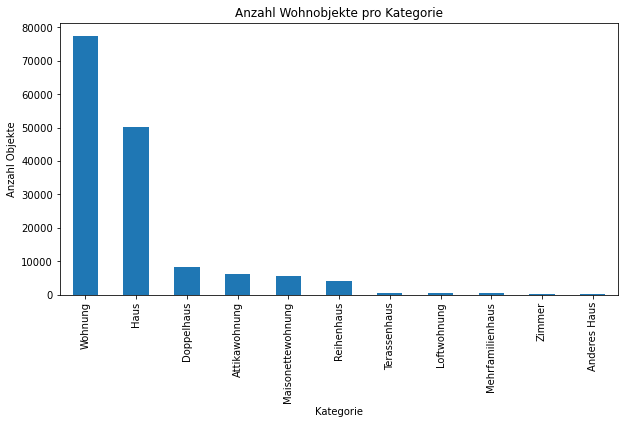

In [5]:
csv_data['GroupNameDe'].value_counts().plot(kind='bar', figsize=(10, 5), rot = 90)
plt.xlabel("Kategorie")
plt.ylabel("Anzahl Objekte")
plt.title("Anzahl Wohnobjekte pro Kategorie")
plt.show()

 Man kann im Plot sehr gut erkennen, dass es sich hier im eine ungleichmäsige Verteilung der Kategorien handelt. Da man einige Kategorien gar nicht erkennen kann, schauen wir noch die Zahlen an:

In [6]:
 csv_data['GroupNameDe'].value_counts()

Wohnung              77499
Haus                 50265
Doppelhaus            8397
Attikawohnung         6215
Maisonettewohnung     5517
Reihenhaus            4168
Terassenhaus           533
Loftwohnung            474
Mehrfamilienhaus       444
Zimmer                  89
Anderes Haus            26
Name: GroupNameDe, dtype: int64

Wir sehen also klar, dass die Daten extrem unbalanced sind. Dazu gibt es verschiedene Techniken. In der Challenge haben wir Oversampling benutzt.

### Oversampling
Oversampling bedeutet, dem Datensatz werden neue Objekte hinzugefügt um eine "Anzahl"-Balance zwischen allen Klassen herzustellen. Hierfür kann man bestehende Objekte zufällig auswählen und mehrmals hinzufügen bzw. kopieren oder komplett neue Objekte – basierend auf den bereits existierenden – erstellen. Dies funktioniert beispielsweise mit der SMOTE Methode. Hiermit werden wir uns auch beschäftigen.

In [7]:
ros = RandomOverSampler(random_state = 69)
X_random_, y_random_ = ros.fit_resample(prepro.X_train, prepro.y_train)
X_random = X_random_.sample(len(prepro.X_train), random_state = 69)
y_random = y_random_.iloc[X_random.index]

### Model trainieren
Wie oben gesagt, wird das NN verglichen mit einem Lightgbm-Mode, welches zu den "Boosted Tree"-Modellen gehört. Die besten Parameter haben wir schon gefunden gehabt mit Hilfe von Bayesian Optimization.

In [8]:
lgbc_best = lgb.LGBMClassifier(
        n_jobs = -1, seed = 42, learning_rate = 0.07517, max_depth = 340, n_estimators = 344,
        num_leaves = 90, reg_alpha = 1.136, reg_lambda = 4.348, device = 'gpu'
)
lgbc_best.fit(X_random, y_random)

LGBMClassifier(device='gpu', learning_rate=0.07517, max_depth=340,
               n_estimators=344, num_leaves=90, reg_alpha=1.136,
               reg_lambda=4.348, seed=42)

In [9]:
lgbc_y_pred_best = lgbc_best.predict(prepro.X_test)

In [10]:
 print(sklearn.metrics.classification_report(prepro.y_test, lgbc_y_pred_best))

                   precision    recall  f1-score   support

     Anderes Haus       0.00      0.00      0.00         5
    Attikawohnung       0.32      0.67      0.43      1243
       Doppelhaus       0.40      0.59      0.48      1679
             Haus       0.92      0.80      0.85     10053
      Loftwohnung       0.45      0.55      0.50        95
Maisonettewohnung       0.28      0.57      0.38      1103
 Mehrfamilienhaus       0.29      0.52      0.38        89
       Reihenhaus       0.37      0.59      0.46       834
     Terassenhaus       0.49      0.64      0.56       107
          Wohnung       0.95      0.80      0.87     15500
           Zimmer       0.13      0.11      0.12        18

         accuracy                           0.76     30726
        macro avg       0.42      0.53      0.46     30726
     weighted avg       0.84      0.76      0.79     30726



In [11]:
prepro.X_test.shape

(30726, 136)

### Confusion Matrix LightGBM

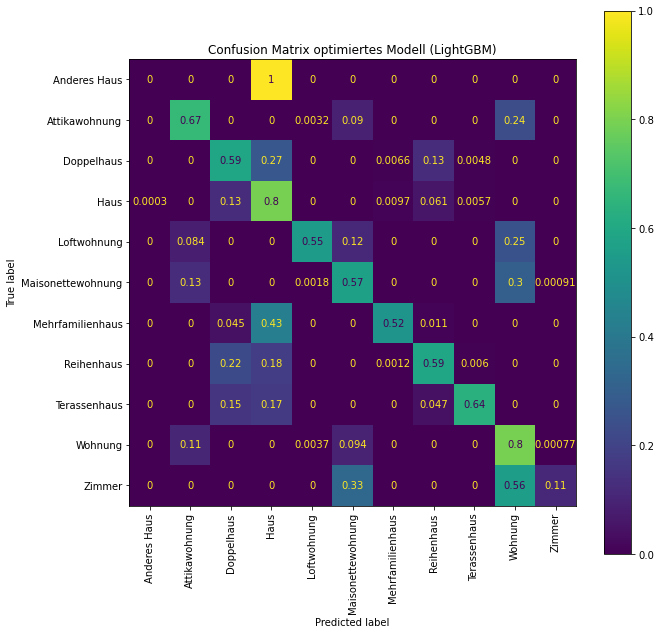

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
sklearn.metrics.plot_confusion_matrix(lgbc_best, prepro.X_test, prepro.y_test, normalize = 'true', xticks_rotation='vertical', ax = ax)
plt.title('Confusion Matrix optimiertes Modell (LightGBM)')
plt.show()

## Wichtigkeit der Features

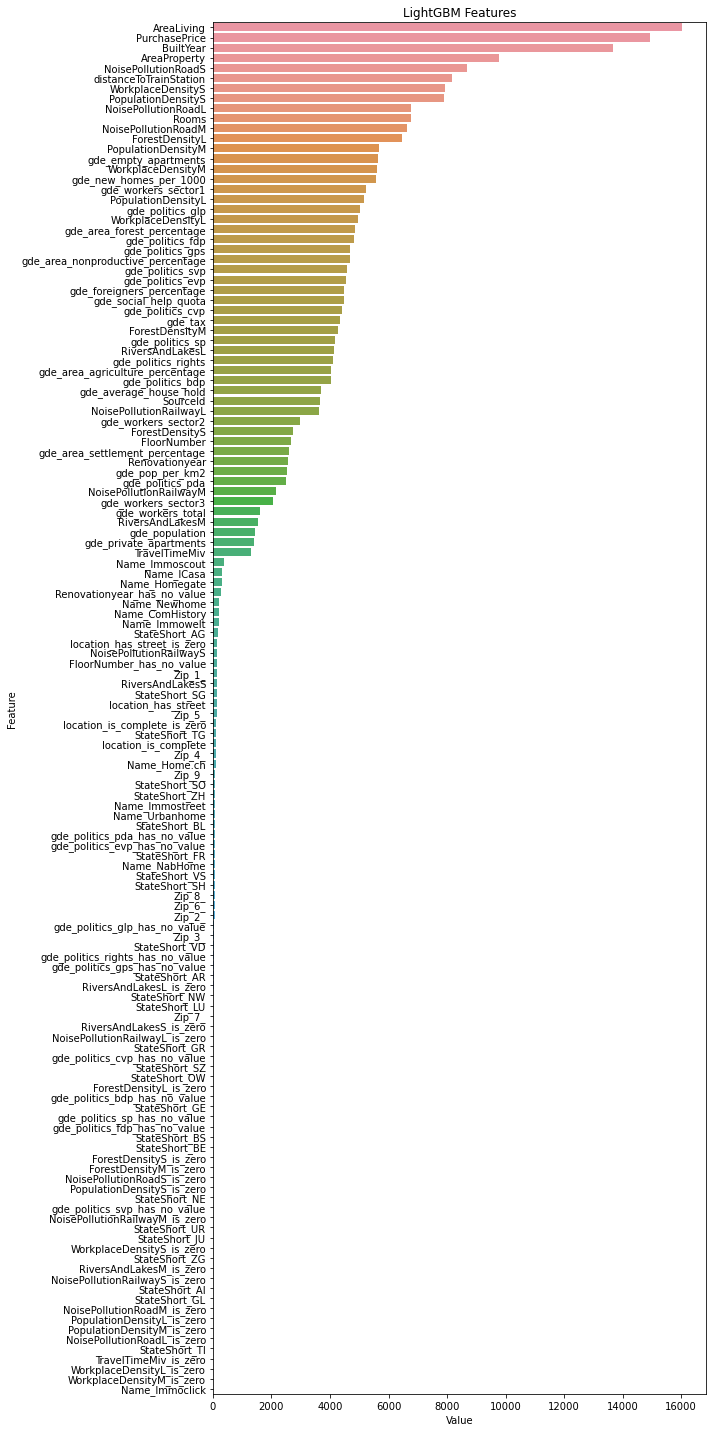

<Figure size 432x288 with 0 Axes>

In [13]:
feature_imp = pd.DataFrame(sorted(zip(lgbc_best.feature_importances_,prepro.X_test.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

Wir sehen also, dass die meisten Features gar keinen Einfluss haben auf die Klassifizierung. Wir stehlen diese Informationen für unser NN um dieses nicht mit Features zu überladen, welche keine Information beinhalten. Für das NN behalten wir also nur diese, welche mehr Einfluss haben als deren Wichtigkeit geteilt durch 2. Damit haben wir noch 53 Features.

In [14]:
features_to_drop = feature_imp[feature_imp.sort_values(by='Value', ascending=False)['Value']<feature_imp.sort_values(by='Value', ascending=False)['Value'].mean()/2]

<ipython-input-14-8b8535232176>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  features_to_drop = feature_imp[feature_imp.sort_values(by='Value', ascending=False)['Value']<feature_imp.sort_values(by='Value', ascending=False)['Value'].mean()/2]


In [15]:
features_to_drop

,Value,Feature
0,0,Name_Immoclick
1,0,NoisePollutionRoadL_is_zero
2,0,NoisePollutionRoadM_is_zero
3,0,PopulationDensityL_is_zero
4,0,PopulationDensityM_is_zero
...,...,...
78,221,Name_Newhome
79,261,Renovationyear_has_no_value
80,300,Name_Homegate
81,316,Name_ICasa


In [19]:
# Save Features to drop:
features_to_drop.to_csv('features_to_drop.csv', index=False)

In [8]:
# Load Features to drop (to avoid having to rerun the whole notebook each time)
features_to_drop = pd.read_csv('features_to_drop.csv')

## Neural Network-Model
LightGBM macht automatisch aus String Zahlen, welche vom Model verstanden werden können. Pytorch macht das nicht; Wir müssen also die Wohnobjekte Onehot-Encoden. Als erstes definieren wir Funktionen, welche ein Model nach folgenden Angaben erstellt:
- Welcher Optimizer verwendet wird (ADAM oder SGD)
- Wieviele Hidden Layers es hat
- Wieviele Neuronen ein Hidden Layer hat
    - Einen guten Anfangswert haben wir mit Hilfe von einem [Artikel auf Stackexchange](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw) gefunden
- Ob regularisiert wird oder nicht mit Dropout
- Falls regularisiert wird, wieviele Neuronen pro Layer sollen jeweils zufälligerweise null gesetzt werden.

## Use of the Library Cuda for the NN 
Currently, this Notebook only runs when Cuda is corrently installed.

In [9]:
if not torch.cuda.is_available():
    NotImplementedError
if torch.cuda.is_available():
    print("Cuda Device Available")
    print("Name of the Cuda Device: ", torch.cuda.get_device_name())
    print("GPU Computational Capablity: ", torch.cuda.get_device_capability())

Cuda Device Available
Name of the Cuda Device:  GeForce RTX 3060 Ti
GPU Computational Capablity:  (8, 6)


### Daten vorbereiten mit der Klasse PreProcessor
Das Preprocessing wird genau gleich durchgeführt wie beim LightGBM. Zusätzlich entfernen wir aber noch die Attribute, welche laut dem LightGBM-Model kaum oder keinen Einfluss haben auf das Model.

### Evaluieren der Modelle
Zur Evaluierung der Modelle benutzen wir Sklearn und nehmen wie beim LightGBM die macro F1-Score.

### Tunen der Hyperparameter
Zum tunen der Hyperparameter benutzen wir das Packet [BayesianOptimization](https://github.com/fmfn/BayesianOptimization), welches Bayesianische globale Optimierung durchführt mit Gauß-Prozessen.


In [10]:
csv_data_fe = csv_data.copy()
## Drop der Reihen mit nur NAs:
csv_data_fe = csv_data_fe[csv_data_fe['TravelTimeMiv'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['StateShort'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['gde_area_settlement_percentage'].notna()].copy()

# Zip vereinfachen:
csv_data_fe['Zip'] = (csv_data_fe['Zip']/1000).astype('int8')
prepro = PreProcessor(csv_data_fe, y_var='GroupNameDe', method_to_encode='onehot_encode', cols_to_drop=['Id', 'LastUpdate', 'Locality', 'StreetAndNr', 'Longitude', 'Latitude', 'HouseObject','RealEstateTypeId'], numbers_to_encode=['Zip'], test_frac=0.2, remove_skew_by_boxcox = True)
prepro.preprocess()


## Drop der Attribute, welche laut dem LightGBM-Model kaum Einfluss haben:
prepro.X_train = prepro.X_train.drop(columns=features_to_drop['Feature'].to_list())
prepro.X_test = prepro.X_test.drop(columns=features_to_drop['Feature'].to_list())

#### Namen label-encoden.
Damit die Gewichte auch der richtigen Klasse entsprechen, definieren wir ein Dictionary, damit das Label-Encoden sicherlich für Train, Test und die Gewichte stimmt.

In [11]:
le_dict = {name:nr for nr, name in enumerate(prepro.y_train.unique())}

In [12]:
y_train_le = prepro.y_train.replace(le_dict)
y_test_le = prepro.y_test.replace(le_dict)

# Create Weights to count for class inbalance:
value_counts_le = prepro.y_train.value_counts().reindex(le_dict)
weights = torch.tensor(1 / (value_counts_le /value_counts_le.sum()), dtype=torch.float32).cuda() 

#### Daten und Modell auf die GPU laden

In [13]:
# Falls wir etwas auf der GPU laufen möchten, müssen wir Pytorch explizit sagen, das es das Model und die benötigten Daten auf die GPU schreiben soll:
if torch.cuda.is_available():
    print("Cuda detected and used by Pytorch!")

else: 
    print("Cuda was not detected and no GPU is used. Training takes a long time, even with a RTX 3060TI, so try to make Pytorch use CUDA.")
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

Cuda detected and used by Pytorch!


#### Dataloader definieren

In [14]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
        'Initialization'
        self.X = X
        self.Y = Y

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        print(self.X[index,:])
        x = self.X[index]
        y = self.Y[index]

        return x, y

In [ ]:
training_set = Dataset(prepro.X_train, y_test_le)

#### Funktionen definieren, um das beste NN zu finden
Wir können mit der Funktion `calc_nr_neuros` einen guten Startwert finden. Es ist natürlich sehr Pi * Daumen gerechnet. Als Parameter haben wir da alpha, 

In [19]:
def calc_nr_neuros(X, output_neurons, alpha=2):
    """
    This function calculates with pi * thumb how many neuros there should be in a hidden layer.
    https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
    :dataframe X: train-dataset which will be given to the NN.
    :numeric alpha: parameter to change the number of neurons in the hidden layer
    :return: starting value for the number of neurons
    """
    sample_size, input_dim = X.shape
    return int(sample_size / (alpha * (input_dim + output_neurons)))

In [22]:
# Parameter for the model
input_dim = prepro.X_train.shape[1]
output_dim = len(y_test_le.unique())
min_neur = calc_nr_neuros(prepro.X_train, output_dim, 10)
max_neur = calc_nr_neuros(prepro.X_train, output_dim, 2)

# Epoch Parameters:
MAX_EPOCHS = 100
MAX_EPOCH_NO_IMPROVE = 15

#EARLY STOPPING PARAMETERS:
MEASURE_FOR_EARLY_STOPPING = 'F1 Score'
SCORING_FUNCTION = sklearn.metrics.f1_score

# Function to use before prediction:
m = nn.Softmax(dim=1)

print("Ein guter Anfangsbereich für die Suche der optimalen Anzahl der Neuronen geht von {} bis {}.".format(min_neur, max_neur))

# Parameter for the Data loader:
params_data_loader = {
    'shuffle': True,
    'num_workers': 0 # I was not able to run num_workers with a higher setting than 0. Found this issue: https://github.com/xingyizhou/CenterNet/issues/566 Apparently it's a problem with jupyter-notebooks.
    }




Ein guter Anfangsbereich für die Suche der optimalen Anzahl der Neuronen geht von 192 bis 960.


### Hilfsfunktionen um das neuronale Netz zu bilden und es zu evaluieren
#### Initalisierung der Gewichte
Die Gewichte werden zufälligerweise mit verschiedenen Methoden initalisiert. Falls wir alle Gewichte mit 0 initalisieren würden, wäre die Ausgabe der Aktivierungsfunktion in den Hidden Layers 0. Somit wäre der Gradient 0 und das NN könnte nicht lernen. Falls wir alle Gewichte mit dem gleichen Wert (z.B 1 ) initalisieren, ist der Output aller Aktivierungsfunktionen in den Hidden Layers identisch und der Gradient für alle Neuronen wieder gleich. Somit werden die Gewichte zufällig initalisiert. Hierzu wurden ebenfalls verschiedene Methoden entwickelt und getestet. Die von Pytorch kann man [hier](https://pytorch.org/docs/stable/nn.init.html) nachlesen. Nachfolgend benutzen wir die Methode `kaiming uniform`, welche uniform Gewichte bestimmt.


In [23]:
def one_hot_ce_loss(outputs, target, weights=None):    
    """
    CrossEntropyLoss accepts only label-encoded predictions. 
    See: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html"""
    if weights is not None:
        criterion = nn.CrossEntropyLoss(weight=weights)
    else: 
        criterion = nn.CrossEntropyLoss()
    return criterion(outputs, target)

def create_model(nr_layers, hdim, dropout, batchnorm, reg):
    """
    :int param nr_layers: How many hidden layers (without input- or output-layer) our NN should have.
    :int hdim: Hidden Dimensions (number of neurons)
    :float drouput: How many % of Neurons should randomy "dropped out".
    :bool batchnorm: If a layer should include batchnorm.
    :bool reg: If regularisation should be applied and which kind.
    :return: Pytorch Model.
    """
    class Model(nn.Module):
        def __init__(self, input_dim, output_dim, nr_layers, hdim, dropout, batchnorm, reg):
            super().__init__()

            self.layers = nn.ModuleList()
            current_dim = input_dim

            for _ in range(nr_layers):
                self.layers.append(nn.Linear(current_dim, hdim))
                if batchnorm:
                    self.layers.append(nn.BatchNorm1d(hdim))
                if reg == 'Dropout':
                    self.layers.append(nn.Dropout(dropout))
                current_dim = hdim
            
            self.layers.append(nn.Linear(current_dim, output_dim))
            self.iniziate_weights()

        def forward(self,x):
            for layer in self.layers[:-1]:
                if isinstance(layer, torch.nn.modules.linear.Linear):
                    x = F.relu(layer(x))
                else:
                    x = layer(x)

            x = self.layers[-1](x)
            #x = F.softmax(self.layers[-1](x), dim=1)
            return x

        def iniziate_weights(self):
            for m in self.layers:
                if isinstance(m, torch.nn.modules.linear.Linear):
                    nn.init.kaiming_uniform_(m.weight)
                    nn.init.constant_(m.bias, 0.01)

                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    return Model(input_dim, output_dim, nr_layers, hdim, dropout, batchnorm, reg)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

In [25]:
def create_NN(optimizer, nr_layers, hdim, dropout, lr_rate, batchnorm, reg):
    """
    :string optimizer: SGD or Adam
    :int param nr_layers: How many hidden layers (without input- or output-layer) our NN should have.
    :int hdim: Hidden Dimensions (number of neurons)
    :float dropout: How many % of Neurons should be randomly "dropped out".
    :float lr_rate: Learning rate.
    :bool batchnorm: If a layer should include batchnorm.
    :string or None reg: If regularisation should be applied and which one.
    :return: Pytorch Model and optimizer-object.
    """
    assert optimizer in ['SGD', 'Adam'], "Please Enter SGD or Adam as Optimizer"
    assert reg in ['Dropout', 'L1', 'L2', None], "Please Enter L1, L2, Dropout or None as reg"
    assert all(isinstance(i, int) for i in [nr_layers, hdim]), "Please check types of Parameter"
    assert all(isinstance(i, float) for i in [dropout, lr_rate]), "Please check types of Parameter"

    model = create_model(nr_layers, hdim, dropout, batchnorm, reg).cuda()

    if optimizer == 'SGD':
        optimizer_object = torch.optim.SGD(params = model.parameters(), lr=lr_rate)
    elif optimizer == 'Adam':
        optimizer_object = torch.optim.Adam(params = model.parameters(), lr=lr_rate)

    return model, optimizer_object

def fit_NN(model, optimizer, reg, reg_factor, BATCH_SIZE, EPOCHS=MAX_EPOCHS, MAX_EPOCH_NO_IMPROVE=MAX_EPOCH_NO_IMPROVE):
    """
    :pytorch model model: Model to train
    :pytorch optimizer optimizer: Optimizer to use for the training (Adam or SGD)
    :string or None reg: If regularisation should be applied and which one.
    :float reg_factor: L1 or L2 Regularisation Factor
    :int BATCH_SIZE: how big one batch should be
    :int EPOCHS: How many epochs should be used for training.
    :int MAX_EPOCHS_NO_IMPROVE: How many epochs can pass with no improvements.
    :float 
    :return: aggregated_losses and test_losses
    """

    # Create Range and lists for saving the losses:
    epoch_loop = range(EPOCHS)
    train_losses = []
    test_losses = []
    test_scores = []

    # Set parameters for early stopping to dummy-value:
    lowest_loss = np.inf
    best_score = 0
    epoch_no_improve = 0


    # Data Generators:
    training_generator = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, **params_data_loader)

    # Move Test data to device:
    y_le_test_t = torch.tensor(y_test_le.values, dtype=torch.uint8).to(device)
    X_test_t = torch.tensor(prepro.X_test.values.astype('float32'), dtype=torch.float32).to(device)


    for i in epoch_loop:
        for x, y in training_generator:
            # Move x, y to device:
            x, y = x.to(device), y.to(device)
            # Predict, calculate loss and update weights
            y_pred = model(x)
            single_loss = one_hot_ce_loss(y_pred, y, weights)

            # Set gradients to zero:
            optimizer.zero_grad()

            # Apply L1/2 Regularisation:
            # Technically, L2 Regularisation can also be passed to the optimizer with the weight_decay parameter. However, this is not                  aviabile for the L1 regularisation directly in the optimizer.
            # Thus, we would need to do L1 regularisation here and L2 in the optimizer, which is annoying.
            l_regularization = torch.tensor(0, dtype=torch.float32).cuda()

            if reg in ['L1', 'L2']:
                for name, param in model.named_parameters():
                        if 'weight' in name:
                            if reg == 'L1':
                                l_regularization += torch.norm(param, 1)**2 * reg_factor
                            elif reg == 'L2':
                                l_regularization += torch.norm(param, 2)**2 * reg_factor
            
            # Update Loss with L Regularisation:
            single_loss += l_regularization

            # Backward Prop:
            single_loss.backward()

            # Update Weights:
            optimizer.step()

            current_loss += single_loss.float()
        
        current_loss = current_loss / nr_batches_per_epoch

        with torch.no_grad():
            current_test_loss = one_hot_ce_loss(model(X_test_t), y_le_test_t, weights)
            current_score = SCORING_FUNCTION(y_le_test_t.cpu(), model(X_test_t).cpu().argmax(axis = 1), average='macro')


        # Easy early stopping implementation:
        if torch.isnan(current_loss).any() or (epoch_no_improve > MAX_EPOCH_NO_IMPROVE):
            break

        if MEASURE_FOR_EARLY_STOPPING == 'F1 Score':
            if i > 1 and best_score < current_score:
                best_score = current_score
                epoch_no_improve = 0

        else:
            if i > 1 and lowest_loss > test_losses[-1]:
                lowest_loss = test_losses[-1]
                epoch_no_improve = 0
        
        epoch_no_improve += 1

        with torch.no_grad():
            train_losses.append(current_loss)
            test_losses.append(current_test_loss)
            test_scores.append(current_score)
    
    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

    return train_losses, test_losses, test_scores

def bayesian_opt_result_to_dict(bay_opt_res, scoring='F1 Score'):
    """
    bayesian optimization result bay_opt_res: Finished object for bayesian optimization.
    returns: DataFrame with results
    """
    results = []
    for result in bay_opt_res:
        dict_ = {scoring: result['target']}
        dict_.update(result['params'])
        results.append(dict_)

    return pd.DataFrame(results).sort_values(by=scoring, ascending=False)


def create_fit_evaluate_NN(optimizer, nr_layers, hdim, dropout, lr_rate, batchnorm, reg, reg_factor, BATCH_SIZE, return_all=False, bay_opt=True):
    """This function puts all the previous functions together; It creates a model, trains it and evaluates it.
    :string optimizer: SGD or Adam
    :int param nr_layers: How many hidden layers (without input- or output-layer) our NN should have.
    :int hdim: Hidden Dimensions (number of neurons)
    :float dropout: How many % of Neurons should be randomly "dropped out".
    :float lr_rate: Learning rate.
    :bool batchnorm: If a layer should include batchnorm.
    :string or None reg: If regularisation should be applied and which one.
    :float reg_factor: L1 or L2 Regularisation Factor
    :int BATCH_SIZE: how big one batch should be
    :int EPOCHS: How many epochs should be used for training.
    :int MAX_EPOCHS_NO_IMPROVE: How many epochs can pass with no improvements.
    :return: Weighted F1 Score and if return_all is set to True, the fitted model, aggregated losses and test losses
    """
    if bay_opt:
        # Cast non-ints to ints for the Bayesian Optimization
        BATCH_SIZE = r_int(BATCH_SIZE)
        hdim = r_int(hdim)
        nr_layers = r_int(nr_layers)
        optimizer = transform_opt(optimizer)
        batchnorm = transform_batchnorm(batchnorm)
        reg = transform_reg(reg)


    model, optimizer_object = create_NN(optimizer, nr_layers, hdim, dropout, lr_rate, batchnorm, reg)
    train_losses, test_losses, test_scores = fit_NN(model, optimizer_object, reg, reg_factor, BATCH_SIZE)

        
    with torch.no_grad():
        f1_score = SCORING_FUNCTION(y_le_test_t.cpu(), model(X_test_t).cpu().argmax(axis = 1), average='macro')

    if return_all:
        return f1_score, model, train_losses, test_losses, test_scores
    
    return f1_score

def r_int(nr):
    """Rounds something to an int and returns it as type int"""
    return int(np.rint(nr))

def transform_reg(reg):
    return 'Dropout' if reg > 1.5 else 'L1' if reg > 1.0 else 'L2' if reg > 0.5 else None 

def transform_batchnorm(batchnorm):
    return True if batchnorm > 0.5 else False

def transform_opt(optimizer):
    return 'Adam' if optimizer > 0.5 else 'SGD'


### Funktion zur Evaluerung von NNs
Mit der Funktion `create_fit_evaluate_NN` haben wir eine Funktion erstellt, welche eine F1-Score zurückgibt und folgende Parameter als Argumente hat:
- optimizer: SGD or Adam
- nr_layers: How many hidden layers (without input- or output-layer) our NN should have.
- hdim: Hidden Dimensions (number of neurons)
- dropout: How many % of Neurons should be randomly "dropped out".
- lr_rate: Learning rate.
- batchnorm: If a layer should include batchnorm.
- reg: If regularisation should be applied. 
- BATCH_SIZE: how big one batch should be
- EPOCHS: How many epochs should be used for training.
- MAX_EPOCHS_NO_IMPROVE: How many epochs can pass with no improvements.

### Bestmögliches Modell ohne Regularisierung, ohne Batchnorm und SGD als Optimizer
Wir finden nun das bestmögliche NN ohne Regularisierung, ohne Batchnorm und SGD als Optimizer mit Bayesian Optimization. Bayesian Optimization kennt nur floats, wir müssen da also ein bisschen tricksen. Die "Tricks" können in der Funktion `create_fit_evaluate_NN` und [hier](https://github.com/fmfn/BayesianOptimization/blob/master/examples/advanced-tour.ipynb) nachgelesen werden.

Kurzgesagt, falls wir Strings, Bools oder Ints als Argumente mitgeben möchten, müssen wir diese mit if-statements umwandeln oder zum Type int casten. 
Beispiel:

`'Dropout' if reg > 1.5 else 'L1' if reg > 1.0 else 'L2' if reg > 0.5 else None`

`BATCH_SIZE = int(BATCH_SIZE)`

In [26]:
# Definieren der Parameter:
pbounds = {
    'optimizer': (0.1, 0.2),
    'nr_layers': (3,6),
    'hdim': (min_neur, max_neur),
    'dropout': (0.0, 0.5),
    'lr_rate': (0.0001, 0.01),
    'batchnorm': (0.0, 0.1),
    'reg': (0.1, 0.2),
    'reg_factor': (0.01, 10),
    'BATCH_SIZE': (64,256)
    }

optimizer = BayesianOptimization(
    f=create_fit_evaluate_NN,
    pbounds=pbounds,
    random_state=1,
)

In [27]:
optimizer.maximize(
    init_points=3,
    n_iter=15,
)

|   iter    |  target   | BATCH_... | batchnorm |  dropout  |   hdim    |  lr_rate  | nr_layers | optimizer |    reg    | reg_fa... |
-------------------------------------------------------------------------------------------------------------------------------------
[-0.67423445 -0.86491233 -0.73583009 -0.01906488  0.0261617   0.
  0.          0.02045154  0.00379216  0.31072734  0.46887352  0.38049585
  0.20998515  0.35360122  0.91299482  0.          0.          0.
 -0.24781451  0.95930525  0.16666667  0.06355638  0.07697505  0.10858478
 -0.15708564 -0.75097913  0.26005877 -0.38725913  0.78081967  0.95266747
 -0.34411605  2.71956388 -0.45576016 -0.06845413 -0.21811527  0.2099925
 -0.40441316 -0.26261045 -0.9774454   0.         -0.50459723 -0.06573945
  0.85322706  0.24841088 -0.13705765 -0.15983604  1.50127059  0.12536272
 -0.56619754 -0.20468358 -0.71309017 -0.135377   -0.83924239]
[-6.74234451e-01 -8.64912331e-01  9.30868679e-02 -1.13124338e-01
  1.08183914e-01  0.00000000e+00  0.00

KeyError: 4047

In [41]:
# Select relevant Features and transform it to a clean DataFrame
relevant_features = ['F1 Score', 'BATCH_SIZE', 'lr_rate', 'hdim', 'nr_layers']
results = bayesian_opt_result_to_dict(optimizer.res)[relevant_features]
results['nr_layers'] = results['nr_layers'].apply(r_int)
results['hdim'] = results['hdim'].apply(r_int)
results['BATCH_SIZE'] = results['BATCH_SIZE'].apply(r_int)
results.head(10)

KeyError: 'F1 Score'

In [ ]:
# Retrain to get the stats:
f1_score, model, aggregated_losses, test_losses = create_fit_evaluate_NN(**optimizer.max['params'], return_all=True)

In [ ]:
plt.plot([tensor_.cpu().detach().numpy() for tensor_ in aggregated_losses], label='Train Loss')
plt.plot([tensor_.cpu().detach().numpy() for tensor_ in test_losses], label='Test Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title('Loss per Epoch. F1 Score: {:.3f}'.format(f1_score))
plt.legend(loc='best')
plt.show()

Der obere Plot zeigt uns klar, dass wir am overfitten sind. Es macht aber sinn, da wir keine Regularisierung anwenden. 

### Bestmögliches Modell mit Dropout oder L1/L2 Regularisation, ohne Batchnorm und SGD als Optimizer
#### Warum Regularisieren?
Der Sinn der regularisierung ist, Overfitting zu verhindern. Dropout tut dies, in dem es einen gewissen %-Satz pro Layer auf 0 setzt. Bei der L1/L2 Regularisierung wird dagegen die absolute oder quadrierte Norm der Gewichte zum Loss hinzuaddiert. Somit verändert sich der Gradient, welcher die Gewichte anpasst. Dies funktioniert, da im Allgemeinen grosse Gewichte auf Overfitting hindeuten und grosse Gewichte werden durch beide L-Regularisierungen bestraft. 

Der Unterschied zwischen L1 und L2 ist, dass bei L1, da man den absoluten Wert nimmt zum summieren, mehr 0 gesetzt. Bei der L2, da die Gewichte quadiert werden und die Quadrierung kleine Werte noch kleiner macht, werden die Gewichte einfach verkleinert, aber werden nicht 0 gesetzt.

In [43]:
# Definieren der Parameter:
training_losses = []

pbounds = {
    'optimizer': (0.1, 0.2),
    'nr_layers': (3,6),
    'hdim': (min_neur, max_neur),
    'dropout': (0.05, 0.3),
    'lr_rate': (0.0001, 0.01),
    'batchnorm': (0.0, 0.1),
    'reg': (0.5, 2),
    'reg_factor': (0.01, 10),
    'BATCH_SIZE': (64,256)
    }

optimizer_reg = BayesianOptimization(
    f=create_fit_evaluate_NN,
    pbounds=pbounds,
    random_state=1,
)

In [44]:
optimizer_reg.maximize(
    init_points=5,
    n_iter=15,
)

|   iter    |  target   | BATCH_... | batchnorm |  dropout  |   hdim    |  lr_rate  | nr_layers | optimizer |    reg    | reg_fa... |
-------------------------------------------------------------------------------------------------------------------------------------
epoch:   0 loss:        nan
|  1        |  0.04482  |  144.1    |  0.07203  |  0.05003  |  424.2    |  0.001553 |  3.277    |  0.1186   |  1.018    |  3.974    |
epoch:   0 loss:        nan
|  2        |  0.04482  |  167.5    |  0.04192  |  0.2213   |  349.0    |  0.008793 |  3.082    |  0.167    |  1.126    |  5.591    |
epoch:  90 loss: 0.6465287805
|  3        |  0.2613   |  90.95    |  0.01981  |  0.2502   |  935.6    |  0.003203 |  5.077    |  0.1876   |  1.842    |  0.8596   |
epoch:  97 loss: 1.2643092871
|  4        |  0.2497   |  71.5     |  0.01698  |  0.2695   |  267.5    |  0.004269 |  5.874    |  0.1533   |  1.538    |  3.162    |
epoch:  87 loss: 0.3496859968
|  5        |  0.3215   |  195.8    |  0.08346  | 

In [45]:
# Select relevant Features and transform it to a clean DataFrame
relevant_features = ['F1 Score', 'BATCH_SIZE', 'lr_rate', 'hdim', 'nr_layers', 'dropout', 'reg', 'reg_factor']
results_reg = bayesian_opt_result_to_dict(optimizer_reg.res)[relevant_features]
results_reg['reg'] = results_reg['reg'].apply(transform_reg)
results_reg['nr_layers'] = results_reg['nr_layers'].apply(r_int)
results_reg['hdim'] = results_reg['hdim'].apply(r_int)
results_reg['BATCH_SIZE'] = results_reg['BATCH_SIZE'].apply(r_int)
results_reg.head(10)

,F1 Score,BATCH_SIZE,lr_rate,hdim,nr_layers,dropout,reg,reg_factor
6,0.378946,64,0.010000,748,3,0.050000,None,10.000000
4,0.321533,196,0.009890,768,5,0.054572,Dropout,1.041228
18,0.310625,103,0.003864,400,4,0.074796,Dropout,4.422262
19,0.307458,193,0.006813,709,3,0.060009,Dropout,2.498971
5,0.282594,256,0.000100,884,6,0.300000,None,10.000000
13,0.280314,70,0.009671,692,5,0.221457,Dropout,5.159439
15,0.262033,143,0.001791,878,3,0.055570,Dropout,3.217227
9,0.261883,165,0.005994,505,3,0.181557,Dropout,7.503248
2,0.261266,91,0.003203,936,5,0.250186,Dropout,0.859592
3,0.249731,71,0.004269,268,6,0.269536,Dropout,3.162001


In [76]:
# Retrain to get the stats:
f1_score_reg, model_reg, aggregated_losses_reg, test_losses_reg = create_fit_evaluate_NN(**optimizer_reg.max['params'], return_all=True)

epoch:  98 loss: 0.0383294262


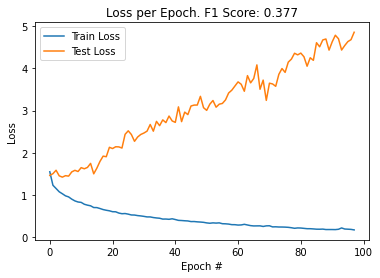

In [77]:
plt.plot([tensor_.cpu().detach().numpy() for tensor_ in aggregated_losses_reg], label='Train Loss')
plt.plot([tensor_.cpu().detach().numpy() for tensor_ in test_losses_reg], label='Test Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title('Loss per Epoch. F1 Score: {:.3f}'.format(f1_score_reg))
plt.legend(loc='best')
plt.show()

### Resultate 
Wir sehen auch hier, dass das Training ab und zu fehlgeschlagen ist und der Loss sich zu "nan gelegt hat. Dies sieht man daran, dass das trainieren sofort abgebrochen wurde (bei der Epoche 0). Warum das genau der Fall ist, weiss ich nicht. Überprüft wurde:
- ob der Input NANs hat
- ob gewisse Attribute nur 0 haben.
- ob Gradienten "sterben", also 0 werden.

Aber nichts davon war richtig. 

Die F1-Score ist aber leicht schlechter als ohne Regularisierung (F1 Score von 0.279702 vs 0.244199).

Wir können die Resultate, welche eine sehr kleine F1 Score haben mit den besseren vergleichen:

In [48]:
results_reg.query('`F1 Score` >= 0.20').mean()

F1 Score        0.277355
BATCH_SIZE    144.615385
lr_rate         0.005351
hdim          621.615385
nr_layers       4.230769
dropout         0.171781
reg_factor      5.339632
dtype: float64

In [49]:
results_reg.query('`F1 Score` >= 0.2')['reg'].value_counts()

Dropout    11
Name: reg, dtype: int64

In [50]:
results_reg.query('`F1 Score` <= 0.1').mean()

F1 Score        0.039765
BATCH_SIZE    161.428571
lr_rate         0.004104
hdim          613.000000
nr_layers       4.000000
dropout         0.164243
reg_factor      4.689276
dtype: float64

In [51]:
results_reg.query('`F1 Score` <= 0.1')['reg'].value_counts()

L2    4
L1    3
Name: reg, dtype: int64

Man sieht hier wieder, dass eine kleine Batch-Size SGD hilft. Dropout als Regularisierungsmethode schneidet besser ab.



Wir können auch noch die NANs analysieren und nachschauen, was da passiert ist:

In [52]:
results_reg.query('`F1 Score` <= 0.0001')

,F1 Score,BATCH_SIZE,lr_rate,hdim,nr_layers,dropout,reg,reg_factor


Es fällt auf, dass bei allen NANs die L1 regularisierung zum Einsatz gekommen ist. 

### Bestmögliches Modell ohne Regularisierung, mit Batchnorm und SGD als Optimizer

In [53]:
# Definieren der Parameter:
training_losses = []

pbounds = {
    'optimizer': (0.1, 0.2),
    'nr_layers': (3,6),
    'hdim': (min_neur, max_neur),
    'dropout': (0.05, 0.3),
    'lr_rate': (0.0001, 0.01),
    'batchnorm': (0.5, 1),
    'reg': (0.0, 0.4),
    'reg_factor': (0.01, 10),
    'BATCH_SIZE': (64,256)
    }

optimizer_BN = BayesianOptimization(
    f=create_fit_evaluate_NN,
    pbounds=pbounds,
    random_state=1,
)

In [54]:
optimizer_BN.maximize(
    init_points=3,
    n_iter=15,
)

|   iter    |  target   | BATCH_... | batchnorm |  dropout  |   hdim    |  lr_rate  | nr_layers | optimizer |    reg    | reg_fa... |
-------------------------------------------------------------------------------------------------------------------------------------
epoch:  44 loss: 0.8216338158
|  1        |  0.2907   |  144.1    |  0.8602   |  0.05003  |  424.2    |  0.001553 |  3.277    |  0.1186   |  0.1382   |  3.974    |
epoch:  77 loss: 0.4377226532
|  2        |  0.3347   |  167.5    |  0.7096   |  0.2213   |  349.0    |  0.008793 |  3.082    |  0.167    |  0.1669   |  5.591    |
epoch: 131 loss: 0.1851597577
|  3        |  0.3805   |  90.95    |  0.5991   |  0.2502   |  935.6    |  0.003203 |  5.077    |  0.1876   |  0.3578   |  0.8596   |
epoch: 117 loss: 0.0305103175
|  4        |  0.3991   |  86.56    |  0.9155   |  0.1069   |  934.1    |  0.009632 |  5.687    |  0.1555   |  0.2736   |  6.437    |
epoch:  89 loss: 0.2528728843
|  5        |  0.3657   |  64.47    |  1.0    

In [55]:
# Select relevant Features and transform it to a clean DataFrame
relevant_features = ['F1 Score', 'optimizer', 'BATCH_SIZE', 'batchnorm','lr_rate', 'hdim', 'nr_layers']
results_BN = bayesian_opt_result_to_dict(optimizer_BN.res)[relevant_features]
results_BN['batchnorm'] = results_BN['batchnorm'].apply(transform_batchnorm)
results_BN['optimizer'] = results_BN['optimizer'].apply(transform_opt)
results_BN['nr_layers'] = results_BN['nr_layers'].apply(r_int)
results_BN['hdim'] = results_BN['hdim'].apply(r_int)
results_BN['BATCH_SIZE'] = results_BN['BATCH_SIZE'].apply(r_int)
results_BN.head(10)

,F1 Score,optimizer,BATCH_SIZE,batchnorm,lr_rate,hdim,nr_layers
3,0.399059,SGD,87,True,0.009632,934,6
6,0.397894,SGD,86,True,0.008577,934,4
2,0.380493,SGD,91,True,0.003203,936,5
16,0.377015,SGD,119,True,0.001850,913,4
7,0.375442,SGD,89,True,0.008520,914,4
15,0.373446,SGD,77,True,0.009877,921,3
8,0.369354,SGD,256,True,0.005550,694,5
10,0.369335,SGD,252,True,0.009005,659,5
5,0.366903,SGD,75,True,0.005473,950,5
4,0.365743,SGD,64,True,0.010000,924,6


In [78]:
# Retrain to get the stats:
f1_score_BN, model_BN, aggregated_losses_BN, test_losses_BN = create_fit_evaluate_NN(**optimizer_BN.max['params'], return_all=True)

KeyboardInterrupt: 

In [ ]:
plt.plot([tensor_.cpu().detach().numpy() for tensor_ in aggregated_losses_BN], label='Train Loss')
plt.plot([tensor_.cpu().detach().numpy() for tensor_ in test_losses_BN], label='Test Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title('Loss per Epoch. F1 Score: {:.3f}'.format(f1_score_BN))
plt.legend(loc='best')
plt.show()

### Resultate
Batchnormnormalisierung hat das Resultat verschlechtert. Man könnte noch mit den Parameter bei der Batchnorm ([Momentum](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)) rumspielen, aber ob es das Ergebniss massiv verbessern würde, ist nicht klar.

### Bestmögliches Modell mit Dropout oder L1/L2 Regularisation, ohne Batchnorm und Adam als Optimizer

In [58]:
# Definieren der Parameter:
training_losses = []

pbounds = {
    'optimizer': (0.5, 1.2),
    'nr_layers': (3,6),
    'hdim': (min_neur, max_neur),
    'dropout': (0.05, 0.3),
    'lr_rate': (0.0001, 0.01),
    'batchnorm': (0.1, 0.4),
    'reg': (0.0, 2.4),
    'reg_factor': (0.01, 10),
    'BATCH_SIZE': (64,256)
    }

optimizer_adam = BayesianOptimization(
    f=create_fit_evaluate_NN,
    pbounds=pbounds,
    random_state=1,
)

In [59]:
optimizer_adam.maximize(
    init_points=5,
    n_iter=15,
)

|   iter    |  target   | BATCH_... | batchnorm |  dropout  |   hdim    |  lr_rate  | nr_layers | optimizer |    reg    | reg_fa... |
-------------------------------------------------------------------------------------------------------------------------------------
epoch:  10 loss: 2.3104679585
|  1        |  0.009421 |  144.1    |  0.3161   |  0.05003  |  424.2    |  0.001553 |  3.277    |  0.6304   |  0.8293   |  3.974    |
epoch:   9 loss: 361451.9687500000
|  2        |  0.006301 |  167.5    |  0.2258   |  0.2213   |  349.0    |  0.008793 |  3.082    |  0.9693   |  1.002    |  5.591    |
epoch:  15 loss: 2.5769112110
|  3        |  0.02015  |  90.95    |  0.1594   |  0.2502   |  935.6    |  0.003203 |  5.077    |  1.113    |  2.147    |  0.8596   |
epoch:  10 loss: 2.0606012344
|  4        |  0.06096  |  71.5     |  0.1509   |  0.2695   |  267.5    |  0.004269 |  5.874    |  0.8732   |  1.661    |  3.162    |
epoch:  16 loss: 1.7923556566
|  5        |  0.05047  |  195.8    |  0.

In [60]:
# Select relevant Features and transform it to a clean DataFrame
relevant_features = ['F1 Score', 'optimizer', 'BATCH_SIZE', 'lr_rate', 'hdim', 'nr_layers', 'dropout', 'reg', 'reg_factor']
results_reg = bayesian_opt_result_to_dict(optimizer_adam.res)[relevant_features]
results_reg['optimizer'] = results_reg['optimizer'].apply(transform_opt)
results_reg['reg'] = results_reg['reg'].apply(transform_reg)
results_reg['nr_layers'] = results_reg['nr_layers'].apply(r_int)
results_reg['hdim'] = results_reg['hdim'].apply(r_int)
results_reg['BATCH_SIZE'] = results_reg['BATCH_SIZE'].apply(r_int)
results_reg.head(10)

,F1 Score,optimizer,BATCH_SIZE,lr_rate,hdim,nr_layers,dropout,reg,reg_factor
9,0.256217,Adam,74,0.000562,271,5,0.228928,Dropout,3.512926
16,0.211972,Adam,74,0.001983,269,4,0.127154,Dropout,0.378422
14,0.185380,Adam,74,0.004827,269,6,0.074767,None,3.884233
10,0.110516,Adam,72,0.007234,271,4,0.159227,None,5.230066
5,0.086969,Adam,197,0.005829,767,5,0.064553,Dropout,0.203690
11,0.060965,Adam,71,0.004949,272,6,0.272372,L1,2.331846
19,0.060965,Adam,73,0.003051,269,4,0.261048,L1,0.944252
3,0.060961,Adam,71,0.004269,268,6,0.269536,Dropout,3.162001
4,0.050465,Adam,196,0.009890,768,5,0.054572,Dropout,1.041228
8,0.049580,Adam,70,0.006194,267,4,0.157633,Dropout,4.552798


In [ ]:
# Retrain to get the stats:
f1_score_adam, model_adam, aggregated_losses_adam, test_losses_adam = create_fit_evaluate_NN(**optimizer_adam.max['params'], return_all=True)

In [ ]:
plt.plot([tensor_.cpu().detach().numpy() for tensor_ in aggregated_losses_adam], label='Train Loss')
plt.plot([tensor_.cpu().detach().numpy() for tensor_ in test_losses_adam], label='Test Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title('Loss per Epoch. F1 Score: {:.3f}'.format(f1_score_adam))
plt.legend(loc='best')
plt.show()

Es scheint, dass eine höhere Batch_size zu einem besseren Resultat führt mit dem Adam optimizer. Wir sehen aber, dass die optimale Batch_Size bei 256 liegt, welches auch die Bbergrenze ist der Parameter. Wir erhöhen die Grenze also. Ebenfalls kann er nun nur zwei Hidden Layers haben:

In [63]:
optimizer_adam.set_bounds(
    new_bounds={
        "BATCH_SIZE": (128, 1024),
        "nr_layers":(2, 6)})

In [64]:
optimizer_adam.maximize(
    init_points=5,
    n_iter=15,
)

|   iter    |  target   | BATCH_... | batchnorm |  dropout  |   hdim    |  lr_rate  | nr_layers | optimizer |    reg    | reg_fa... |
-------------------------------------------------------------------------------------------------------------------------------------
epoch:  22 loss: 2.3227753639
|  21       |  0.04482  |  529.3    |  0.3726   |  0.1234   |  413.0    |  0.001387 |  2.077    |  0.9752   |  0.5079   |  2.663    |
epoch:  11 loss: 2.3538563251
|  22       |  0.007069 |  568.4    |  0.116    |  0.1935   |  304.7    |  0.005934 |  4.799    |  0.5716   |  0.9937   |  6.947    |
epoch:  23 loss: 1.7256277800
|  23       |  0.1339   |  499.1    |  0.115    |  0.184    |  701.8    |  0.005197 |  5.778    |  0.9106   |  2.168    |  1.383    |
epoch:  24 loss: 2.0114719868
|  24       |  0.05051  |  252.8    |  0.3422   |  0.1494   |  319.0    |  0.009282 |  3.391    |  1.026    |  1.742    |  8.834    |
epoch:  19 loss: 1.4604175091
|  25       |  0.1096   |  686.8    |  0.3253 

In [65]:
20*5*15 / 60 

25.0

In [ ]:
# Retrain to get the stats:
f1_score_adam_2, model_adam_2, aggregated_losses_adam_2, test_losses_adam_2 = create_fit_evaluate_NN(**optimizer_adam.max['params'], return_all=True)

In [ ]:
plt.plot([tensor_.cpu().detach().numpy() for tensor_ in aggregated_losses_adam_2], label='Train Loss')
plt.plot([tensor_.cpu().detach().numpy() for tensor_ in test_losses_adam_2], label='Test Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title('Loss per Epoch. F1 Score: {:.3f}'.format(f1_score_adam_2))
plt.legend(loc='best')
plt.show()

In [68]:
fig, ax = plt.subplots(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y_ohc_test_t.cpu().argmax(axis = 1), model(X_test_t).cpu().argmax(axis = 1))
plot_confusion_matrix(cm, enc.categories_[0], normalize=True)

NameError: name 'y_ohc_test_t' is not defined